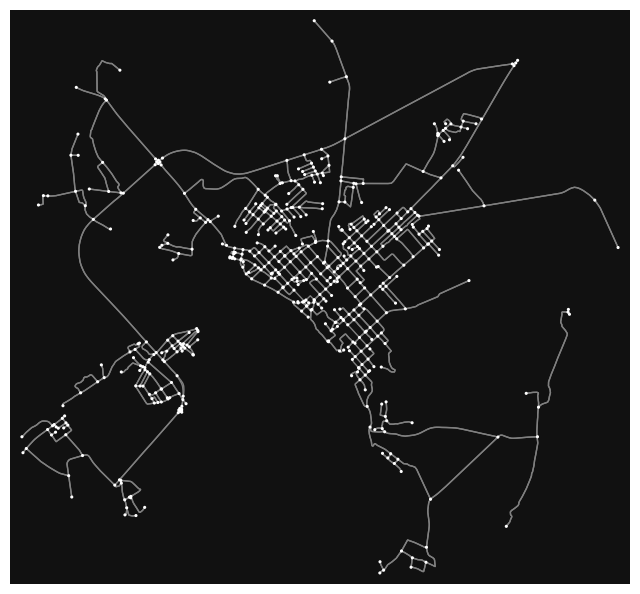

Центральность по степени:


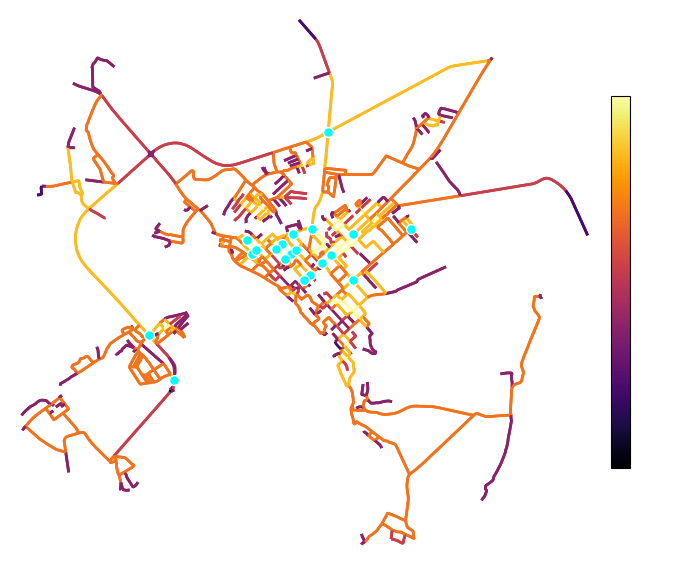

Центральность по близости:


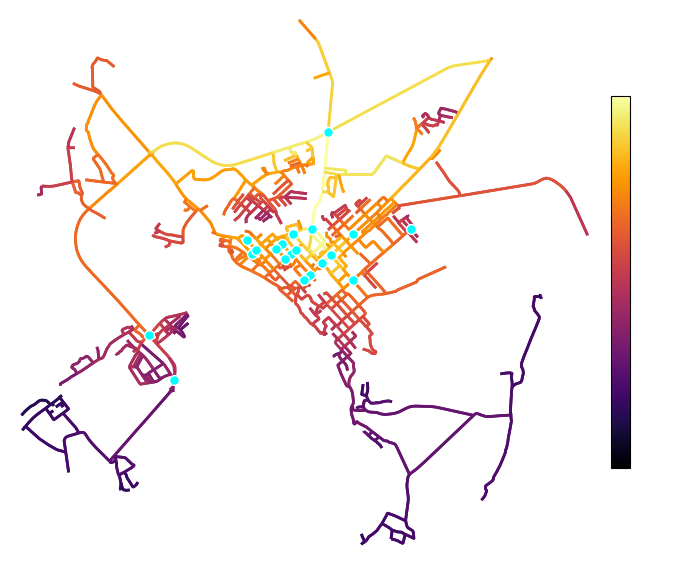


Поиск транспортных проблем:


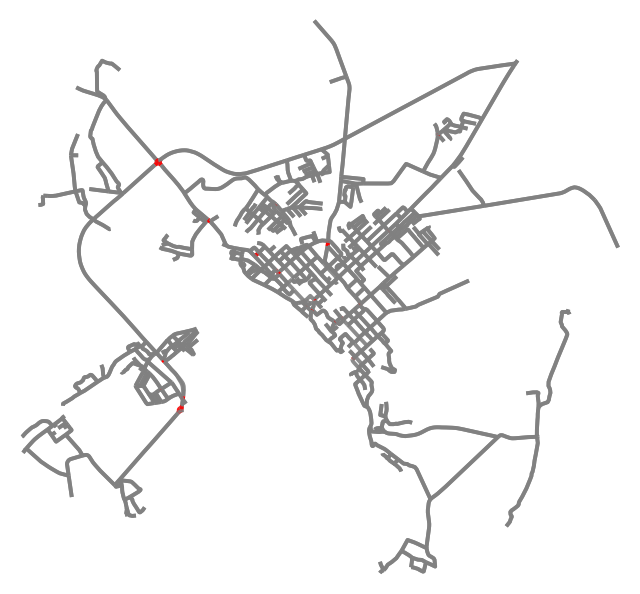

Топ проблемных участков:
1. Без названия (1325512694 → 624687158) | Score: 0.0027 | Betweenness: 0.06059 | Длина: 7.3 м | Мин. степень: 3
2. Без названия (3396516148 → 6989087858) | Score: 0.0016 | Betweenness: 0.05833 | Длина: 6.0 м | Мин. степень: 6
3. Без названия (3396497601 → 1420752983) | Score: 0.0009 | Betweenness: 0.06134 | Длина: 11.0 м | Мин. степень: 6
4. Без названия (1420752983 → 3396497601) | Score: 0.0009 | Betweenness: 0.05956 | Длина: 11.0 м | Мин. степень: 6
5. Октябрьская улица (670340299 → 3388972997) | Score: 0.0009 | Betweenness: 0.06412 | Длина: 14.2 м | Мин. степень: 5
6. Без названия (602647232 → 602647218) | Score: 0.0009 | Betweenness: 0.17827 | Длина: 49.8 м | Мин. степень: 4
7. улица Рязанский Спуск (602494990 → 602495002) | Score: 0.0008 | Betweenness: 0.06995 | Длина: 16.8 м | Мин. степень: 5
8. Без названия (602647230 → 602647232) | Score: 0.0008 | Betweenness: 0.15734 | Длина: 48.8 м | Мин. степень: 4
9. Без названия (624687158 → 602736172) | Score: 0.

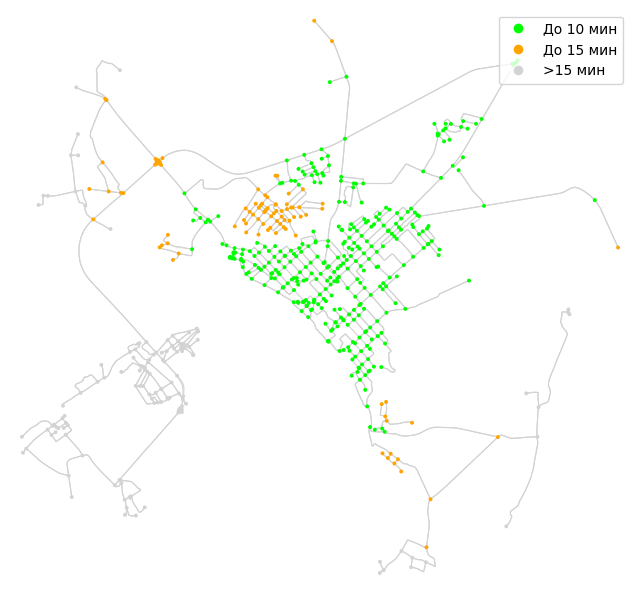

In [87]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import pandas as pd
from shapely.geometry import Point
import numpy as np


class TransportNetworkModel:
    def __init__(self, place_name: str, buffer_dist: int = 2000, network_type="drive"):
        self.place_name = place_name
        self.buffer_dist = buffer_dist
        self.network_type = network_type
        self.graph = None

    def download_graph(self):
        gdf = ox.geocode_to_gdf(self.place_name)
        polygon = gdf.geometry.values[0]
        polygon_utm, crs_utm = ox.projection.project_geometry(polygon)
        buffered_utm = polygon_utm.buffer(self.buffer_dist)
        buffered_latlon, _ = ox.projection.project_geometry(buffered_utm, crs=crs_utm, to_latlong=True)
        self.graph = ox.graph_from_polygon(buffered_latlon, network_type=self.network_type)

    def show_graph(self):
        ox.plot_graph(self.graph, node_size=5, edge_color='gray')

    def find_centralities(self):
        line_G = nx.line_graph(self.graph)

        print("Центральность по степени:")
        edge_centrality = nx.degree_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        """print("Центральность по собственному вектору:")
        edge_centrality = nx.eigenvector_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)"""

        print("Центральность по близости:")
        edge_centrality = nx.closeness_centrality(line_G)
        self.show_centrality_heatmap(edge_centrality)

        # print("Центральность по посредничеству:")
        # edge_centrality = nx.betweenness_centrality(line_G)
        # self.show_centrality_heatmap(edge_centrality)

    def show_centrality_heatmap(self, edge_centrality, highlight_top_nodes=True):
        ev = []
        for edge in self.graph.edges(keys=False):
            edge_key = edge + (0,)
            val = edge_centrality.get(edge_key, 0)
            ev.append(val)

        norm = colors.Normalize(vmin=min(ev) * 0.8, vmax=max(ev))
        cmap = cm.ScalarMappable(norm=norm, cmap=cm.inferno)
        ec = [cmap.to_rgba(val) for val in ev]

        fig, ax = ox.plot_graph(
            self.graph,
            bgcolor='black',
            node_size=0,
            edge_color=ec,
            edge_linewidth=2,
            edge_alpha=1,
            show=False,
            close=False
        )

        if highlight_top_nodes:
            node_centrality = nx.degree_centrality(self.graph)
            top_nodes = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
            gdf_nodes = ox.graph_to_gdfs(self.graph, edges=False)
            for node_id, score in top_nodes:
                geom = gdf_nodes.loc[node_id].geometry
                ax.scatter(geom.x, geom.y, s=50, c='cyan', edgecolors='white', zorder=5)

        cbar = plt.colorbar(cmap, ax=ax, fraction=0.03, pad=0.02)
        #cbar.set_label("Центральность рёбер")
        cbar.ax.yaxis.set_tick_params(color='white')
        plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

        #ax.set_title("Тепловая карта центральности рёбер", fontsize=12, color='white')
        ax.set_axis_off()
        plt.show()

    def find_bottlenecks(self, top_k=50):
        """
        Поиск проблемных участков:
        - Высокая междуцентральность (узкие горлышки)
        - Малая степень у узлов (мало обходных путей)
        - Маленькая длина (мосты, переезды)
        """
        print("\nПоиск транспортных проблем:")

        simple_graph = nx.DiGraph()
        for u, v, data in self.graph.edges(data=True):
            length = data.get("length", 1)
            if simple_graph.has_edge(u, v):
                simple_graph[u][v]["length"] = min(simple_graph[u][v]["length"], length)
            else:
                simple_graph.add_edge(u, v, length=length)

        edge_betweenness = nx.edge_betweenness_centrality(simple_graph, weight="length")

        edge_scores = []

        for u, v, k in self.graph.edges(keys=True):
            edge = (u, v, k)

            btwn = edge_betweenness.get((u, v), 0) or edge_betweenness.get((v, u), 0)

            length = self.graph[u][v][k].get("length", 1)
            deg_u = self.graph.degree(u)
            deg_v = self.graph.degree(v)
            min_deg = min(deg_u, deg_v)

            score = (btwn / length) * (1 / (min_deg + 0.1))
            edge_scores.append((edge, score, btwn, length, min_deg))

        edge_scores.sort(key=lambda x: x[1], reverse=True)
        worst_edges = [edge for edge, *_ in edge_scores[:top_k]]

        edge_colors = []
        for edge in self.graph.edges(keys=True):
            if edge in worst_edges:
                edge_colors.append("red")
            else:
                edge_colors.append("gray")

        fig, ax = ox.plot_graph(
            self.graph,
            edge_color=edge_colors,
            edge_linewidth=2.8,
            node_size=0,
            edge_alpha=0.9,
            bgcolor="white",
            show=False,
            close=False
        )
        plt.show()

        print("Топ проблемных участков:")
        for i, (edge, score, btwn, length, min_deg) in enumerate(edge_scores[:top_k]):
            u, v, k = edge
            street_name = self.graph[u][v][k].get("name", "Без названия")
            print(
                f"{i+1}. {street_name} ({u} → {v}) | Score: {score:.4f} | "
                f"Betweenness: {btwn:.5f} | Длина: {length:.1f} м | Мин. степень: {min_deg}"
            )

    def analyze_station_metrics(self, station_coords, speed_kmh=30):
        print("\nМетрики для вокзала:")

        station_node = ox.distance.nearest_nodes(self.graph, X=station_coords[1], Y=station_coords[0])

        # Центральность по близости
        closeness = nx.degree_centrality(self.graph)
        closeness_value = closeness[station_node]
        print(f"Центральность по близости: {closeness_value:.5f}")

        # Среднее время в пути
        lengths = nx.single_source_dijkstra_path_length(self.graph, station_node, weight="length")
        avg_distance_m = np.mean(list(lengths.values()))
        avg_time_min = avg_distance_m / (speed_kmh * 1000 / 60)
        print(f"Среднее время в пути: {avg_time_min:.1f} мин")

        # Доступность
        time_10_m = (10 / 60) * speed_kmh * 1000
        time_15_m = (15 / 60) * speed_kmh * 1000

        reachable_10 = [n for n, d in lengths.items() if d <= time_10_m]
        reachable_15 = [n for n, d in lengths.items() if d <= time_15_m]

        max_dist = max(lengths.values()) if lengths else 0
        print(f"Макс. расстояние: {max_dist/1000:.2f} км (~{max_dist/(speed_kmh * 1000 / 60):.1f} мин)")

        node_colors = []
        for node in self.graph.nodes:
            if node in reachable_10:
                node_colors.append("lime")
            elif node in reachable_15:
                node_colors.append("orange")
            else:
                node_colors.append("lightgray")

        fig, ax = ox.plot_graph(
            self.graph,
            node_color=node_colors,
            node_size=8,
            edge_color="lightgray",
            edge_linewidth=0.8,
            bgcolor="white",
            show=False,
            close=False
        )

        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='До 10 мин', markerfacecolor='lime', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='До 15 мин', markerfacecolor='orange', markersize=8),
            Line2D([0], [0], marker='o', color='w', label='>15 мин', markerfacecolor='lightgray', markersize=8),
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        #ax.set_title("Транспортная доступность вокзала", fontsize=12)
        ax.set_axis_off()
        plt.show()


model = TransportNetworkModel(place_name="Касимов, Рязанская область, Россия", buffer_dist=2500)
model.download_graph()
model.show_graph()
model.find_centralities()
model.find_bottlenecks()
model.analyze_station_metrics(station_coords=(54.946817, 41.409804))

# nodes = sorted(list(nx.closeness_centrality(model.graph).items()), key=lambda i: i[1], reverse=True)
# print(*nodes[:10], sep='\n')

In [88]:
def compute_centrality(self):
    print("Вычисление центральности рёбер:")

    line_graph = nx.line_graph(self.graph)
    centrality = nx.closeness_centrality(line_graph)

    for (u, v, k), cent_value in centrality.items():
        self.graph[u][v][k]["centrality"] = cent_value

    edge_values = [
        self.graph[u][v][k].get("centrality", 0)
        for u, v, k in self.graph.edges(keys=True)
    ]

    norm = colors.Normalize(vmin=min(edge_values), vmax=max(edge_values))
    cmap = cm.ScalarMappable(norm=norm, cmap=cm.plasma)
    edge_colors = [cmap.to_rgba(val) for val in edge_values]

    fig, ax = ox.plot_graph(
        self.graph,
        node_size=0,
        edge_color=edge_colors,
        edge_linewidth=2,
        edge_alpha=0.9,
        bgcolor="white"
    )

In [89]:
def analyze_dead_ends_and_isolation(self):
    print("Анализ тупиков и изолированных участков:")

    dead_ends = [node for node, degree in dict(self.graph.degree()).items() if degree == 1]
    print(f"Найдено {len(dead_ends)} тупиков.")

    nodes_gdf, _ = ox.graph_to_gdfs(self.graph)
    positions = nodes_gdf.geometry.apply(lambda point: (point.x, point.y)).to_dict()

    fig, ax = ox.plot_graph(self.graph, show=False, close=False)

    nx.draw_networkx_nodes(
        self.graph,
        pos=positions,
        nodelist=dead_ends,
        node_color="red",
        node_size=20,
        ax=ax
    )

    plt.title("Тупики на транспортной сети", color="white")
    ax.set_facecolor("black")
    plt.show()

In [90]:
def find_potential_bottlenecks(self, top_k=30):
    print("\nАнализ узких мест:")
    line_G = nx.line_graph(self.graph)
    
    edge_betweenness = nx.betweenness_centrality(line_G)

    centrality_list = [
        (edge, centrality)
        for edge, centrality in edge_betweenness.items()
    ]

    centrality_list.sort(key=lambda x: x[1], reverse=True)

    top_edges = [edge for edge, _ in centrality_list[:top_k]]

    edge_colors = []
    for edge in self.graph.edges(keys=True):
        if edge in top_edges:
            edge_colors.append("red")  # узкое место
        else:
            edge_colors.append("gray")  # обычный участок

    fig, ax = ox.plot_graph(
        self.graph,
        edge_color=edge_colors,
        edge_linewidth=2,
        node_size=0,
        edge_alpha=0.9,
        bgcolor="white",
        show=False,
        close=False
    )
    ax.set_title("Наиболее загруженные участки (bottlenecks)", fontsize=12)
    plt.show()

    print("Наиболее потенциально перегруженные участки (по междуцентральности):")
    for i, (edge, value) in enumerate(centrality_list[:top_k]):
        print(f"{i+1}. {edge} — значение: {value:.5f}")

In [91]:
def find_potential_bottlenecks(self):
    edges = ox.graph_to_gdfs(self.graph, nodes=False, edges=True)

    potential_issues = edges[
        (edges["highway"].isin(["residential", "tertiary", "unclassified", "service"])) |
        (edges["lanes"].fillna("1").astype(str) == "1")
    ]

    print("Возможные проблемные участки (бутылочные горлышки):")
    print(potential_issues[["name", "highway", "lanes"]].dropna().head(10))

    fig, ax = ox.plot_graph(self.graph, show=False, close=False)
    potential_issues.plot(ax=ax, color="red", linewidth=2)
    plt.show()